In [1]:
import os
import random
import glob
import gc
import csv
import torch
import time
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from math import floor

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary

from PIL import Image
import seaborn as sns
import plotly.io as pio
pio.renderers.default = "vscode"

In [2]:
TRA_PATH = 'data/train/'
TST_PATH = 'data/test/'
LABEL_PATH = 'data/train.csv'
SEED = 5566
use_gpu = torch.cuda.is_available()
device = torch.device("cuda" if use_gpu else "cpu")
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [3]:
emotion_cat = {0:'Anger', 1:'Disgust', 2:'Fear', 3:'Happiness', 4: 'Sadness', 5: 'Surprise', 6: 'Neutral'}

def load_train_data(label_path):
    train_label = pd.read_csv(label_path)['label'].values.tolist()
    train_image = [f'data/train/{i+7000}.jpg' for i in range(len(train_label))]
    return train_image, train_label

def load_test_data(img_path):
    test_set = [f'{img_path}/{i}.jpg' for i in range(7000)]
    return test_set

In [4]:
class FaceExpressionDataset(Dataset):
    def __init__(self, data, label, augment=None):
        self.data = data
        self.label = label
        self.augment = augment

    def __len__(self):
        return len(self.data)
    
    def read_img(self, idx):
        img = Image.open(self.data[idx])
        img = torch.from_numpy(np.array(img)).float()
        if not self.augment is None:
            img = self.augment(img)
        return img
    
    def __getitem__(self, idx):
        img = self.read_img(idx)
        label = self.label[idx]
        return img, label
    
class TestingDataset(Dataset):
    def __init__(self, data, augment=None):
        self.data = data
        self.augment = augment

    def __len__(self):
        return len(self.data)
    
    def read_img(self, idx):
        img = Image.open(self.data[idx])
        img = torch.from_numpy(np.array(img)).float()
        if not self.augment is None:
            img = self.augment(img)
        return img
    
    def __getitem__(self, idx):
        img = self.read_img(idx)
        return img

In [5]:
train_image, train_label = load_train_data(LABEL_PATH)
test_set = load_test_data(TST_PATH) 
train_image, valid_image, train_label, valid_label = train_test_split(train_image, train_label, stratify=train_label)

In [6]:
#運用資料集的圖片算出
mean_img = 0.5081561803817749
std_img = 0.2644411027431488
image_transforms = {'train':transforms.Compose([
                transforms.ToPILImage(),
                transforms.RandomVerticalFlip(),
                transforms.RandomRotation(degrees = (-20, 20)),
                transforms.ToTensor(),
                transforms.Normalize(mean=mean_img, std=std_img)
                     ]),
            'valid': transforms.Compose([
                transforms.ToPILImage(),
                transforms.ToTensor(),
                transforms.Normalize(mean=mean_img, std=std_img)
                    ]),
            'test': transforms.Compose([
                transforms.ToPILImage(),
                transforms.ToTensor(),
                transforms.Normalize(mean=mean_img, std=std_img)
                ])
            }
train_dataset = FaceExpressionDataset(train_image, train_label, image_transforms["train"])
valid_dataset = FaceExpressionDataset(valid_image, valid_label, image_transforms["valid"])
test_dataset = TestingDataset(test_set, image_transforms["test"])

In [7]:
class FaceExpressionNet(nn.Module):
    def __init__(self):
        super(FaceExpressionNet, self).__init__()

        ###########################general information###########################
        self.conv1_out_channels = 64
        self.leakyReLU1_slope = 0.05
        self.conv1_dropout_rate = 0.2

        self.conv0 = nn.Sequential(
            nn.Conv2d(1, self.conv1_out_channels, kernel_size=5, padding=2),
            nn.LeakyReLU(negative_slope=self.leakyReLU1_slope),
            nn.BatchNorm2d(self.conv1_out_channels),
            nn.Dropout2d(0.2)
        )
        self.conv1 = nn.Sequential(
            nn.Conv2d(self.conv1_out_channels, self.conv1_out_channels, kernel_size=5, padding=2),
            nn.LeakyReLU(negative_slope=self.leakyReLU1_slope),
            nn.BatchNorm2d(self.conv1_out_channels),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.25)
        )

        #########################location information######################
        self.conv2_out_channels = 512
        self.leakyReLU2_slope = 0.05
        self.conv2_dropout_rate = 0.5
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(self.conv1_out_channels, 128, kernel_size=3, padding=1),
            nn.LeakyReLU(negative_slope=self.leakyReLU2_slope),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.3)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, self.conv2_out_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(negative_slope=self.leakyReLU2_slope),
            nn.BatchNorm2d(self.conv2_out_channels),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.4)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(self.conv2_out_channels, self.conv2_out_channels, kernel_size=3,padding=1),
            nn.LeakyReLU(negative_slope=self.leakyReLU2_slope),
            nn.BatchNorm2d(self.conv2_out_channels),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.5)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(4*4*self.conv2_out_channels, self.conv2_out_channels),
            nn.ReLU(),
            nn.BatchNorm1d(self.conv2_out_channels),
            nn.Dropout(0.5)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(self.conv2_out_channels, self.conv2_out_channels),
            nn.ReLU(),
            nn.BatchNorm1d(self.conv2_out_channels),
            nn.Dropout(0.5)
        )
        self.fc3 = nn.Linear(self.conv2_out_channels, 7)

    def forward(self, x):
        x = self.conv0(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(-1, 4*4*self.conv2_out_channels)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [8]:
def train(train_loader, model, loss_fn, optimizer, device):
    model.train()
    gc.collect()
    torch.cuda.empty_cache()
    train_loss = []
    train_acc = []
    for (img, label) in train_loader:
        img = img.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        output = model(img)
        loss = loss_fn(output, label)
        loss.backward()            
        optimizer.step()
        with torch.no_grad():
            predict = torch.argmax(output, dim=-1)
            acc = np.mean((label == predict).cpu().numpy())
            train_acc.append(acc)
            train_loss.append(loss.item())
        del img, label, output, loss, predict, acc
        torch.cuda.empty_cache()
    train_acc = np.mean(train_acc)
    train_loss = np.mean(train_loss)
    return train_acc, train_loss
    
    
def valid(valid_loader, model, loss_fn, device):
    model.eval()
    with torch.no_grad():
        valid_loss = []
        valid_acc = []
        for idx, (img, label) in enumerate(valid_loader):
            img = img.to(device)
            label = label.to(device)
            output = model(img)
            loss = loss_fn(output, label)
            predict = torch.argmax(output, dim=-1)
            acc = (label == predict).cpu().tolist()
            valid_loss.append(loss.item())
            valid_acc += acc
            del img, label, output, loss, predict, acc
            torch.cuda.empty_cache()

    valid_acc = np.mean(valid_acc)
    valid_loss = np.mean(valid_loss)
    gc.collect()
    torch.cuda.empty_cache()
    return valid_acc, valid_loss

def save_checkpoint(model, prefix='model_b06702064'):
    checkpoint_path = f'{prefix}.pth'
    torch.save(model.state_dict(), checkpoint_path)
    #print('model saved to %s' % checkpoint_path)

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model = FaceExpressionNet()
model.apply(init_weights)
model.to(device)

#tunning
optimizer_name = "Adam"
lr = 0.01
batch_size = 128

optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

num_epoch = 500

#build data loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)      

#record
acc_record = []
best_valid_acc = 0
best_valid_loss = 999999
best_epoch = 0

no_update_cnt = 0
patience = 10
x = time.time()
for epoch in range(num_epoch):

    train_acc, train_loss = train(train_loader, model, loss_fn, optimizer, device)
    valid_acc, valid_loss = valid(valid_loader, model, loss_fn, device)
    acc_record.append(valid_acc)
    if valid_acc > best_valid_acc:
        model_name = "model_best"
        save_checkpoint(model, optimizer, prefix=model_name)
        best_valid_loss = valid_loss
        best_valid_acc = valid_acc
        best_epoch = epoch
        no_update_cnt = 0
    else:
        no_update_cnt += 1
    y = time.time()
    time_train = (y - x) / 60
    print(f"Epoch {epoch}: {round(time_train, 2)} min elapsed, train acc: {round(train_acc * 100, 2)}%, train loss: {round(train_loss, 3)}, valid acc: {round(valid_acc * 100, 2)}%, valid loss: {round(valid_loss, 3)}")
    gc.collect()
    torch.cuda.empty_cache()
    #Early stop
    if no_update_cnt > patience:
        break

print('########################################################')
print("Finish model tuning")
print(f"Best epoch is {best_epoch}, Accuracy: {best_valid_acc}, Loss: {best_valid_loss}")
print('########################################################')

# Validation

In [11]:
def predict(data_loader, model, device, isValid = False, isTesting = False):
    model.eval()
    with torch.no_grad():
        predict_result = []
        if isValid:
            for (img, label) in data_loader:
                img = img.to(device)
                output = model(img)
                predict = torch.argmax(output, dim=-1).tolist()
                predict_result += predict
        if isTesting:
            for img in data_loader:
                img = img.to(device)
                output = model(img)
                predict = torch.argmax(output, dim=-1).tolist()
                predict_result += predict
    return predict_result

In [20]:
model = FaceExpressionNet()
model.load_state_dict(torch.load("./model_best.pth"))
model = model.to(device)
batch_size = 1024
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
valid_pred = predict(valid_loader, model, device, isValid = True)

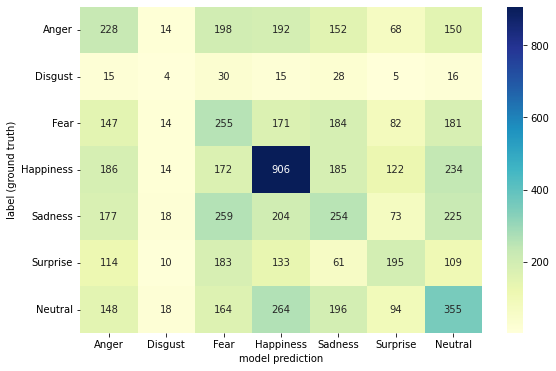

In [29]:
cf_matrix = confusion_matrix(valid_label, valid_pred)                                
# 計算每個class的accuracy
per_cls_acc = cf_matrix.diagonal()/cf_matrix.sum(axis=0)
emotion_cat = {0:'Anger', 1:'Disgust', 2:'Fear', 3:'Happiness', 4: 'Sadness', 5: 'Surprise', 6: 'Neutral'}                  
class_names = list(emotion_cat.values())

df_cm = pd.DataFrame(cf_matrix, class_names, class_names)     
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.xlabel("model prediction")
plt.ylabel("label (ground truth)")
plt.savefig("confusion_matrix.png")

# Tesing

In [12]:
def write_to_csv(predict_result, file_name):
    with open(file_name, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['id', 'label'])
        for i in range(len(predict_result)):
            writer.writerow([str(i), str(predict_result[i])])

In [13]:
model = FaceExpressionNet()
model.load_state_dict(torch.load("./model_best.pth"))
model = model.to(device)
batch_size = 1024
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
test_pred = predict(test_loader, model, device, isValid = False, isTesting = True)
write_to_csv(test_pred, './submission.csv')

# 讀取npy檔案來預測結果

In [30]:
X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')
y_train = np.load("y_train.npy")

In [31]:
class FaceExpressionDataset(Dataset):
    def __init__(self, X, y, augment=None):
        self.X = X
        self.y = y
        self.augment = augment

    def __len__(self):
        return len(self.X)
    
    def read_img(self, idx):
        img = self.X[idx]
        if not self.augment is None:
            img = self.augment(img)
        img = img.float()
        return img
    
    def __getitem__(self, idx):
        img = self.read_img(idx)
        label = self.y[idx]
        return img, label
    
class TestingDataset(Dataset):
    def __init__(self, X, augment=None):
        self.X = X
        self.augment = augment

    def __len__(self):
        return len(self.X)

    def read_img(self, idx):
        img = self.X[idx]
        if not self.augment is None:
            img = self.augment(img)
        img = img.float()
        return img
        
    def __getitem__(self, idx):
        img = self.read_img(idx)
        return img

In [32]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, stratify=y_train)
train_dataset = FaceExpressionDataset(X_train, y_train, image_transforms["train"])

valid_dataset = FaceExpressionDataset(X_valid, y_valid, image_transforms["valid"])
test_dataset = TestingDataset(X_test, image_transforms["test"])

In [33]:
def predict(data_loader, model, device, isValid = False, isTesting = False):
    model.eval()
    with torch.no_grad():
        predict_result = []
        if isValid:
            for (img, label) in data_loader:
                img = img.to(device)
                output = model(img)
                predict = torch.argmax(output, dim=-1).tolist()
                predict_result += predict
        if isTesting:
            for img in data_loader:
                img = img.to(device)
                output = model(img)
                predict = torch.argmax(output, dim=-1).tolist()
                predict_result += predict
    return predict_result

In [41]:
model = FaceExpressionNet()
model.load_state_dict(torch.load("./model_best.pth"))
model = model.to(device)
batch_size = 1024
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
valid_pred = predict(valid_loader, model, device, isValid = True)

In [42]:
valid_label = np.array(valid_dataset.y)
correct = sum((valid_pred == valid_label))
print(correct/len(valid_label))

0.6877596233730269


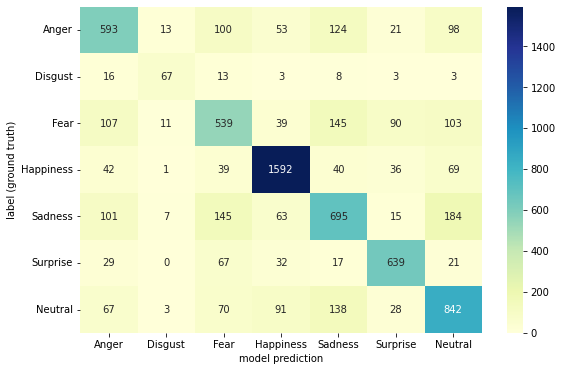

In [43]:
cf_matrix = confusion_matrix(valid_label, valid_pred)                                
# 計算每個class的accuracy
per_cls_acc = cf_matrix.diagonal()/cf_matrix.sum(axis=0)
emotion_cat = {0:'Anger', 1:'Disgust', 2:'Fear', 3:'Happiness', 4: 'Sadness', 5: 'Surprise', 6: 'Neutral'}                  
class_names = list(emotion_cat.values())

df_cm = pd.DataFrame(cf_matrix, class_names, class_names)     
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.xlabel("model prediction")
plt.ylabel("label (ground truth)")
plt.savefig("confusion_matrix.png")

In [45]:
#Testing
def write_to_csv(predict_result, file_name):
    with open(file_name, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['id', 'label'])
        for i in range(len(predict_result)):
            writer.writerow([str(i), str(predict_result[i])])

model = FaceExpressionNet()
model.load_state_dict(torch.load("./model_best.pth"))
model = model.to(device)
batch_size = 1024
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
test_pred = predict(test_loader, model, device, isValid = False, isTesting = True)
write_to_csv(test_pred, './submission_npy.csv')